In [10]:
%matplotlib inline
from matplotlib import rc
rc("text", usetex=False)
from fourierPSF.fourierModel import *
from mavis import *
# %load_ext line_profiler

In [11]:
path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
parser = ConfigParser()
aa = parser.read(path + parametersFile + '.ini')
wvl = eval(parser.get('PSF_DIRECTIONS', 'ScienceWavelength'))[0]  # lambda
tel_radius = eval(parser.get('PSF_DIRECTIONS', 'psInMas'))/2
pixel_psf = eval(parser.get('telescope', 'TelescopeDiameter'))      # mas
gridElements = 7
NGS_flux = [10000, 30000, 5000]
NGS_SR_1650 = [0.4, 0.2, 0.6]
NGS_FWHM_mas = [90, 110, 85]
polarNGSCoords = np.asarray([[30.0,0.0], [50.0,100.0],[10.0,240.0]])
#polarNGSCoords = np.asarray([[10.0,0.0], [10.0,120.0],[10.0,240.0]])

In [12]:
xx, yy = np.linspace(-15, 15, gridElements), np.linspace(-15,15, gridElements)
cartPointingCoords =  np.dstack(np.meshgrid(xx, yy)).reshape(-1, 2)
cartNGSCoords = np.asarray([polarToCartesian(polarNGSCoords[0,:]), polarToCartesian(polarNGSCoords[1,:]), polarToCartesian(polarNGSCoords[2,:])])
mLO = MavisLO("/home/frossi/dev/MASTSEL/", 'mavisParams', 'data/windpsd_mavis.fits')

In [13]:
Ctot = mLO.computeTotalResidualMatrix(cartPointingCoords, cartNGSCoords, NGS_flux, NGS_SR_1650, NGS_FWHM_mas)
cov_ellipses = mLO.ellipsesFromCovMats(Ctot)

In [14]:
#%lprun -f fourierModel.__init__ 
fao = fourierModel("/home/frossi/dev/MASTSEL/mavisParams.ini", calcPSF=False, verbose=False, display=False)
#%lprun -f fourierModel.optimalProjector fao = fourierModel("parFileMAVIS", nyquistSampling=True, calcPSF=False, verbose=False, display=False)
PSD = fao.powerSpectrumDensity()
N = PSD[0].shape[0] # 400
print(N)

[6.4e-07]
'parameters'  4.61 ms
'tomographicReconstructor'  265.05 ms
'optimalProjector'  132.37 ms
'finalReconstructor'  473.65 ms
'controller'  29.54 ms
'__init__'  579.50 ms
'noisePSD'  3.81 ms
'spatioTemporalPSD'  8.77 ms
'fittingPSD'  12.23 ms
'powerSpectrumDensity'  27.69 ms
446


In [15]:
freq_range = fao.freqRange
pitch = 1/freq_range
grid_diameter = pitch*N

psd = Field(wvl, N, freq_range, 'rad')
psd.sampling =  cp.asarray(PSD[0] * (wvl/np.pi)**2)
mask = Field(wvl, N, pitch*N)
sx = int(TelescopeDiameter/pitch)+1
mask.sampling = cp.asarray(congrid(fao.tel.pupil, [sx, sx]))
mask.sampling = zeroPad(mask.sampling, (N-sx)//2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


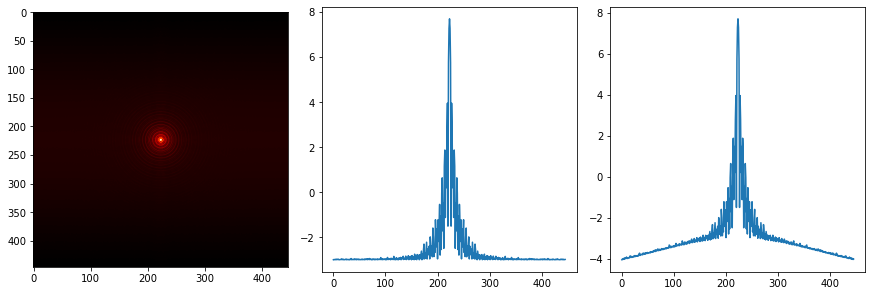

Wavelength:  6.4e-07
Grid side elements:  446
width:  1.4350485395472229e-05 [ rad ]
width:  2960.0028700970793 [ mas ]
pixel_size:  3.21759762230319e-08 [ rad ]
pixel_size:  6.636777735643675 [ mas ]


In [16]:
psfLongExp = longExposurePsf(mask, psd)
psfLongExp.standardPlot(True)
psfLongExp.printStatus()

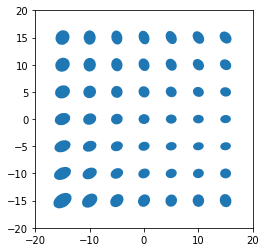

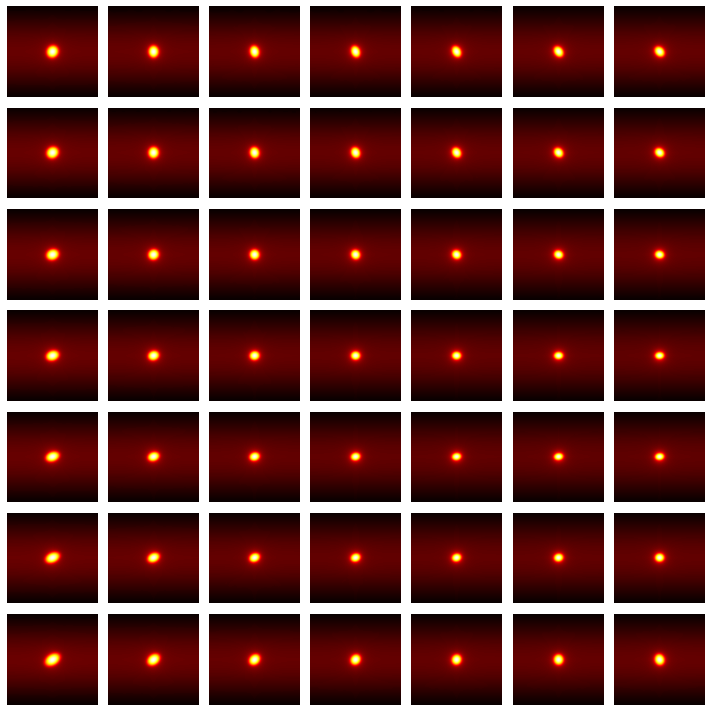

In [17]:
results = []
for ellp in cov_ellipses:
    results.append(convolve(psfLongExp, residualToSpectrum(ellp, N, psf_FoV)))

plotEllipses(cartPointingCoords, cov_ellipses, 0.4)
tiledDispaly(results)

In [18]:
#hdul1 = fits.HDUList()
#hdul1.append(fits.PrimaryHDU())
#hdul1.append(fits.ImageHDU(data=fao.PSF[0]))
#hdul1.writeto('psfOlivier.fits')